In [196]:
# Step 1: Import Libraries & Download NLTK Resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vrajp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vrajp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vrajp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Step 2: Load Dataset from CSV
df = pd.read_csv("C:\\Users\\vrajp\\Text_classification\\IMDB Dataset.csv")

df.columns = df.columns.str.strip()
print("Columns:", df.columns.tolist())

df = df.rename(columns={
    "customer_review_text": "review",
    "review_text": "review",    
    "sentiment": "label"
})

df = df[["review", "label"]]
print(df.head())

Columns: ['review', 'sentiment']
                                              review     label
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [198]:
# Step 3: Quick Exploratory Data Analysis
print("Label distribution:\n", df['label'].value_counts())
df.sample(5)

Label distribution:
 label
positive    25000
negative    25000
Name: count, dtype: int64


,review,label
27264,Dolph Lundgren stars as a former cop/boxer who...,negative
45452,Christopher Nolan's directorial debut is a mem...,positive
5531,Back in 1985 I caught this thing (I can't even...,negative
41731,"""A Bug's Life"" is like a favorite candy bar --...",positive
29770,I just saw this at the Toronto International F...,positive


In [207]:
# Step 4: Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["clean_review"] = df["review"].apply(preprocess)
df[["review", "clean_review"]].head()

# Remove empty rows after cleaning
df['clean_review'].replace('', np.nan, inplace=True)
df.dropna(subset=['clean_review', 'label'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("After cleaning:")
print(df.isnull().sum())
print("Rows:", len(df))

After cleaning:
review          0
label           0
clean_review    0
dtype: int64
Rows: 50000


C:\Users\vrajp\AppData\Local\Temp\ipykernel_19680\2100772457.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['clean_review'].replace('', np.nan, inplace=True)


In [ ]:
# Step 5: Feature Extraction placeholder (not used)
# (We will extract features ONLY AFTER splitting)
X = df["clean_review"]
y = df["label"]
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X)
print("Shape of TF-IDF matrix:", X_tfidf.shape)
print("combined shape:", X_tfidf.shape[0] + X_tfidf.shape[1])

In [201]:
# Step 6: Train-Test Split (split BEFORE vectorization)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df["clean_review"], 
    df["label"], 
    test_size=0.2, 
    random_state=42,
    stratify=df["label"]
)

print("Raw split successful:")
print("X_train_raw:", len(X_train_raw))
print("X_test_raw:", len(X_test_raw))


# Step 6.1: TF-IDF Vectorization (fit only on training data)
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = tfidf.fit_transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)

print("Vectorization complete:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Raw split successful:
X_train_raw: 40000
X_test_raw: 10000
Vectorization complete:
X_train: (40000, 5000)
X_test: (10000, 5000)


In [202]:
# Step 7: Train Models
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Models trained successfully.")

Models trained successfully.


In [203]:
# Step 8: Evaluation Metrics
print("Naive Bayes Performance")
print(classification_report(y_test, nb_preds))

print("Logistic Regression Performance")
print(classification_report(y_test, lr_preds))

Naive Bayes Performance
              precision    recall  f1-score   support

    negative       0.86      0.84      0.85      5000
    positive       0.84      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Logistic Regression Performance
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5000
    positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



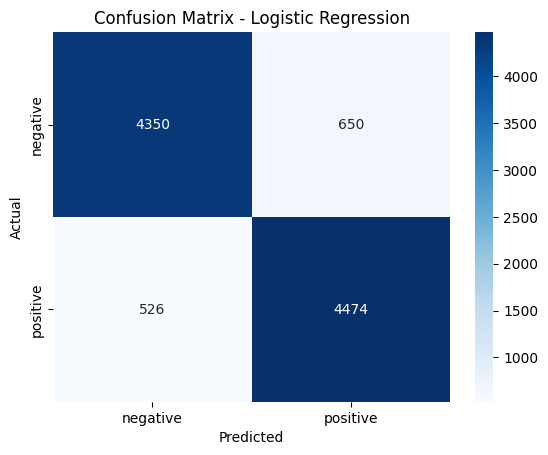

In [204]:
# Step 9: Confusion Matrix Visualization
cm = confusion_matrix(y_test, lr_preds)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lr_model.classes_,
    yticklabels=lr_model.classes_
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [205]:
# Step 10: Custom Review Prediction
def predict_custom_review(review_text):
    clean = preprocess(review_text)
    vector = tfidf.transform([clean])

    lr_pred = lr_model.predict(vector)[0]
    nb_pred = nb_model.predict(vector)[0]

    print("\nOriginal Review:", review_text)
    print("Cleaned Review:", clean)
    print("\nPrediction:")
    print("Logistic Regression →", lr_pred)
    print("Naive Bayes →", nb_pred)

user_input = input("Enter a customer review to analyze: ")
predict_custom_review(user_input)


Original Review: worst acting ever
Cleaned Review: worst acting ever

Prediction:
Logistic Regression → negative
Naive Bayes → negative


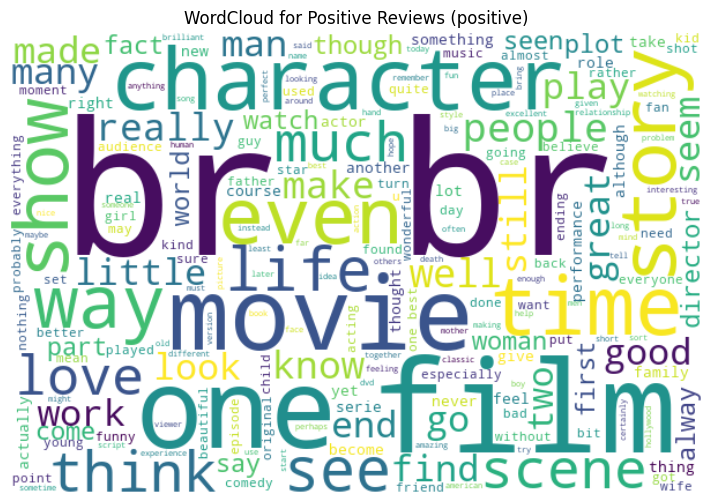

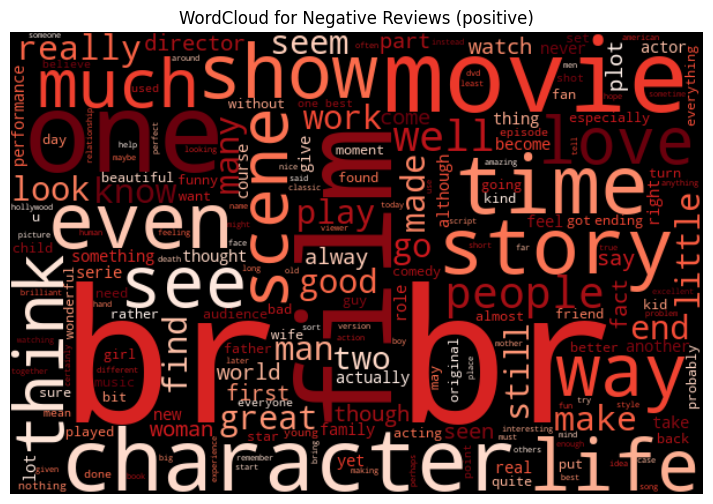

In [206]:
# Step 11: WordClouds for Positive & Negative Sentiment
pos_label = df["label"].value_counts().idxmax()
neg_label = df["label"].value_counts().idxmin()

# Positive WordCloud
positive_text = " ".join(df[df["label"] == pos_label]["clean_review"])

plt.figure(figsize=(12,6))
wc = WordCloud(width=600, height=400, background_color="white").generate(positive_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud for Positive Reviews ({pos_label})")
plt.show()

# Negative WordCloud
negative_text = " ".join(df[df["label"] == neg_label]["clean_review"])

plt.figure(figsize=(12,6))
wc = WordCloud(width=600, height=400, background_color="black", colormap="Reds").generate(negative_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud for Negative Reviews ({neg_label})")
plt.show()